In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
import torch.nn.functional as F
use_gpu = torch.cuda.is_available()
torch.cuda.set_device(3)
from torchsummary import summary
from glob import glob
from PIL import Image

In [2]:
# #clean dataset
# for img in glob("/home/jovyan/EJ/causality/chexnet/database/images/*png"):
#     try:
#         im = Image.open(img)
#     except OSError as e:
#         os.remove(img)
        

In [3]:
data_dir = 'database/'
trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
image_datasets = datasets.ImageFolder(data_dir,trans)
dataloders = torch.utils.data.DataLoader(image_datasets, batch_size=8,
                                             shuffle=True)
dataset_sizes = len(image_datasets)
use_gpu = torch.cuda.is_available()
dataset_sizes

54737

# LOAD MODEL

In [4]:
import warnings
warnings.filterwarnings('ignore')
densenet121 = models.densenet121(pretrained=False)
kernelCount = densenet121.classifier.in_features
densenet121.classifier = nn.Sequential(nn.Linear(kernelCount, 14), nn.Softmax())
if use_gpu:                 
    densenet121 = densenet121.cuda()       
densenet121 = densenet121.float()

In [5]:
checkpoint = torch.load("models/m-25012018-123527.pth.tar")
from collections import OrderedDict
new_state_dict = OrderedDict()
checkpoint["state_dict"]
for k, v in checkpoint["state_dict"].items():
    name = k[19:] # remove module.`
    name = name.replace("norm.1","norm1")
    name = name.replace("norm.2","norm2")
    name = name.replace("conv.1","conv1")
    name = name.replace("conv.2","conv2")
    new_state_dict[name] = v
densenet121.load_state_dict(new_state_dict)


In [6]:
if use_gpu:             
    densenet121 = densenet121.cuda()       
densenet121 = densenet121.float()
summary(densenet121,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           8,192
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          36,864
      BatchNorm2d-11           [-1, 96, 56, 56]             192
             ReLU-12           [-1, 96, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]          12,288
      BatchNorm2d-14          [-1, 128,

In [7]:
freeze_layer = 6
f_model = list(densenet121.features.children())[:freeze_layer]
f_model = nn.Sequential(*f_model)
r_model = list(densenet121.features.children())[freeze_layer:len(list(densenet121.features.children()))]
r_model = nn.Sequential(*r_model)
cls_model = nn.Sequential(*list(densenet121.classifier.children()))
r_freeze = list(densenet121.features.children())[freeze_layer:len(list(densenet121.features.children()))]
r_freeze = nn.Sequential(*r_freeze)
cls_freeze = nn.Sequential(*list(densenet121.classifier.children()))

for param in r_freeze.parameters():
    param.requires_grad = False
for param in cls_freeze.parameters():
    param.requires_grad = False
print(f_model)
print(cls_model)
# densenet121

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
 

In [8]:
ae1 = nn.Conv2d(in_channels=128,out_channels=32,kernel_size=(3,3),padding=(1, 1))
hd1 = nn.Conv2d(in_channels=32,out_channels=16,kernel_size=(3,3),padding=(1, 1))
hd2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),padding=(1, 1))
ae2 = nn.Conv2d(in_channels=32,out_channels=128,kernel_size=(3,3),padding=(1, 1))

In [9]:
class dense_auto(nn.Module):
    def __init__(self):
        super(dense_auto, self).__init__()
        self.f_model = f_model
        self.ae1 = ae1
        self.hd1 = hd1
        self.hd2 = hd2
        self.ae1 = ae1
        self.ae2 = ae2
        self.r_model = r_model
        self.r_freeze = r_freeze
        self.r_model = r_model
        self.cls_model = cls_model
        self.cls_freeze = cls_freeze
        self.zero_out = np.random.randint(0,16)
        self.prob_zero = np.random.uniform(0,1,1)
        
    def forward_interpret(self,x):
        x = hd1(x)
        x[:,5,:,:] = 0
        x = hd2(x)
        return x
    
    def forward_shallow(self,x):
        x = self.ae1(x)
        y1 = x.clone()
        x = self.forward_interpret(x)
        y2 = x.clone()
        x = self.ae2(x)
        return x, y1,y2
    
    def forward(self, x):
        x = self.f_model(x)
        x2 = x.clone()
        y, y1,y2 = self.forward_shallow(x)
        y3 = y.clone()
        features = self.r_model(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        x = self.cls_model(out)
        features_freeze = r_freeze(y)
        out_f = F.relu(features_freeze, inplace=True)
        out_f = F.adaptive_avg_pool2d(out_f, (1, 1)).view(features_freeze.size(0), -1)
        y = cls_freeze(out_f)
        return x, x2, y, y1, y2, y3


In [10]:
def tvloss(yhat, y):
    bsize, chan, height, width = y.size()
    errors = []
    dy = torch.abs(y[:,:,1:,:] - y[:,:,:-1,:])
    dyhat = torch.abs(yhat[:,:,1:,:] - yhat[:,:,:-1,:])
    error = torch.norm(dy - dyhat, 1)
    return error / height

In [11]:
from tqdm import tqdm
save_path = "causal_dense_zeroout_last2conv.pth"
def train_causal_model(c_model, optimizer, num_epochs=10):
    best_model_wts = c_model.state_dict()
    for epoch in range(num_epochs):
        c_model.train(True)  # Set model to training mode
        
        running_loss = 0.0
        test_loss = 10

        for data in tqdm(dataloders):
            inputs,labels = data
            if use_gpu:
                inputs = Variable(inputs.cuda())
            else:
                inputs = Variable(inputs)

            optimizer.zero_grad()
            
            x,x2,y,y1,y2,y3 = c_model(inputs)
#             loss_interpret = nn.CrossEntropyLoss()(y1,y2.detach().long())
            loss_interpret = tvloss(y1,y2)
            loss_ae = nn.L1Loss()(x2,y3.detach())
            loss_kl = nn.KLDivLoss()(F.log_softmax(y,-1), x.detach())

            loss = 5*loss_interpret + 2*loss_ae + 3*loss_interpret
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / dataset_sizes
#         if epoch % 100 == 0:
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('Loss: {:.10f} '.format(epoch_loss))

        # deep copy the model
        if test_loss > epoch_loss:
            test_loss = epoch_loss
            best_model_wts = c_model.state_dict()
            state = {'model':c_model.state_dict(),'optim':optimizer.state_dict()}
            torch.save(state,save_path)

    # load best model weights
    c_model.load_state_dict(best_model_wts)
    return c_model

In [12]:
causal_model = dense_auto().cuda()
optimizer_c = optim.Adam(filter(lambda p: p.requires_grad,causal_model.parameters()), lr=0.001)
for name, param in causal_model.named_parameters():
#     if "r_model" in name:
#         param.requires_grad = True
    if param.requires_grad:
        print(name)

f_model.0.weight
f_model.1.weight
f_model.1.bias
f_model.4.denselayer1.norm1.weight
f_model.4.denselayer1.norm1.bias
f_model.4.denselayer1.conv1.weight
f_model.4.denselayer1.norm2.weight
f_model.4.denselayer1.norm2.bias
f_model.4.denselayer1.conv2.weight
f_model.4.denselayer2.norm1.weight
f_model.4.denselayer2.norm1.bias
f_model.4.denselayer2.conv1.weight
f_model.4.denselayer2.norm2.weight
f_model.4.denselayer2.norm2.bias
f_model.4.denselayer2.conv2.weight
f_model.4.denselayer3.norm1.weight
f_model.4.denselayer3.norm1.bias
f_model.4.denselayer3.conv1.weight
f_model.4.denselayer3.norm2.weight
f_model.4.denselayer3.norm2.bias
f_model.4.denselayer3.conv2.weight
f_model.4.denselayer4.norm1.weight
f_model.4.denselayer4.norm1.bias
f_model.4.denselayer4.conv1.weight
f_model.4.denselayer4.norm2.weight
f_model.4.denselayer4.norm2.bias
f_model.4.denselayer4.conv2.weight
f_model.4.denselayer5.norm1.weight
f_model.4.denselayer5.norm1.bias
f_model.4.denselayer5.conv1.weight
f_model.4.denselayer5.no

In [13]:
import warnings
warnings.filterwarnings('ignore')
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
train_causal_model(causal_model,optimizer_c,num_epochs=1)

100%|██████████| 6843/6843 [28:54<00:00,  3.95it/s]


Epoch 0/0
Loss: 0.3733902256 


dense_auto(
  (f_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2

In [14]:
causal_eval = dense_auto().cuda()
checkpoint = torch.load("causal_dense_zeroout.pth")
causal_eval.load_state_dict(checkpoint["model"])

FileNotFoundError: [Errno 2] No such file or directory: 'causal_dense_zeroout.pth'

In [21]:
from PIL import Image
def computingECE(causal_model,image):
    img = Image.open(image).convert('RGB')
    trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    img = trans(img)
    img.unsqueeze_(0)
    img = img.cuda()
    outputs = causal_model(img)
    score = outputs[0][0]
    print(torch.max(score,0))
#     print(score)
    
    causal_score = outputs[2][0]
    print(torch.max(causal_score,0))
    causal_effect = causal_score - score
#     print(causal_effect)
    ece = torch.dot(causal_effect,score)
    return ece
image_path = "database/original_images/00000001_000.png"
ece = computingECE(causal_model,image_path)
ece

(tensor(0.4588, device='cuda:3'), tensor(3, device='cuda:3'))
(tensor(0.4669, device='cuda:3'), tensor(3, device='cuda:3'))


tensor(1.00000e-03 *
       3.9109, device='cuda:3')

## OVERLAP

In [38]:
from PIL import Image
import cv2
import matplotlib.cm as cm
def computingECE(causal_model,image):
    img = cv2.imread(image,1)
#     display = img
    dx = img.shape[0] / 10
    dy = img.shape[1] / 10
    blocks = [12,22,23,32,33]
    for channel in range(img.shape[2]):
        for block in blocks:
            img[int((block-1)*dx):int((block)*dx),int((block-1)*dy):int((block)*dy)] = 255
    display = img
    img = Image.fromarray(img)
    trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    img = trans(img)
    img.unsqueeze_(0)
    img = img.cuda()
    outputs = causal_model(img)
    score = F.softmax(outputs[0],1).view(-1)
#     print(torch.max(score,0))
#     print(score)
    
    causal_score = F.softmax(outputs[2],1).view(-1)
#     print(torch.max(causal_score,0))
    causal_effect = causal_score - score
#     print(causal_effect)
    ece = torch.dot(causal_effect,score)
    return ece,display

tensor(1.00000e-05 *
       2.0835, device='cuda:3')

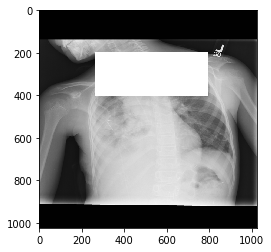

In [48]:
image_path = "/home/jovyan/EJ/causality/CheXNet-Keras/data/masked_data/bbox/00007830_013.png"
ece,display = computingECE(causal_model,image_path)
plt.imshow(display)
ece

## FOOLBOX

In [58]:
from PIL import Image
import cv2

img_fool = Image.open(image_path).convert("RGB")
trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
img_fool = trans(img_fool)
img_fool.cuda()
print("img to cuda")
print(torch.max(img_fool))

import foolbox
from foolbox.models import PyTorchModel
vgg_fool = models.vgg16(pretrained=True).eval()
vgg_fool.cuda()

fool_model = foolbox.models.PyTorchModel(vgg_fool, bounds=(-3,3), num_classes=1000)

img_fool = img_fool.cpu().numpy()
print(img_fool.shape)
print(np.argmax(fool_model.predictions(img_fool)))
label = np.argmax(fool_model.predictions(img_fool))

# apply attack on source image
attack = foolbox.attacks.FGSM(fool_model)
adversarial = attack(img_fool, label)
print('adversarial class', np.argmax(fool_model.predictions(adversarial)))

img to cuda
tensor(2.6400)
(3, 224, 224)
999
adversarial class 578


array([[[-2.0995793, -2.0995793, -2.0995793, ..., -2.0995793,
         -2.0995793, -2.0995793],
        [-2.0995793, -2.0995793, -2.1019793, ..., -2.0995793,
         -2.0995793, -2.0995793],
        [-2.1019793, -2.0995793, -2.0995793, ..., -2.0995793,
         -2.0995793, -2.0995793],
        ...,
        [-2.1019793, -2.0995793, -2.0995793, ..., -2.1019793,
         -2.0995793, -2.0995793],
        [-2.1019793, -2.0995793, -2.0995793, ..., -2.1019793,
         -2.0995793, -2.1019793],
        [-2.0995793, -2.0995793, -2.0995793, ..., -2.0995793,
         -2.0995793, -2.0995793]],

       [[-2.0194073, -2.0194073, -2.0194073, ..., -2.0170074,
         -2.0170074, -2.0170074],
        [-2.0194073, -2.0194073, -2.0194073, ..., -2.0170074,
         -2.0170074, -2.0170074],
        [-2.0194073, -2.0194073, -2.0194073, ..., -2.0194073,
         -2.0194073, -2.0194073],
        ...,
        [-2.0194073, -2.0194073, -2.0194073, ..., -2.0194073,
         -2.0194073, -2.0194073],
        [-2.